Regularized Regression
========

# Theory

**Regularized regression** methods modify ordinary least squares by adding a penalty term to prevent overfitting and improve generalization. The two most common methods are **Ridge regression** (L2) and **Lasso regression** (L1).

## The Overfitting Problem

Ordinary Least Squares (OLS) minimizes:
$$\text{OLS}: \quad \min_\beta \|\mathbf{y} - \mathbf{X}\beta\|_2^2$$

With many features or collinear predictors, OLS can:
- Produce large, unstable coefficients
- Overfit training data
- Generalize poorly to new data

## Ridge Regression (L2 Regularization)

**Ridge regression** adds an L2 penalty on coefficient magnitudes:
$$\text{Ridge}: \quad \min_\beta \|\mathbf{y} - \mathbf{X}\beta\|_2^2 + \lambda\|\beta\|_2^2$$

where $\lambda \geq 0$ is the regularization parameter.

### Closed-Form Solution
$$\hat{\beta}_{\text{ridge}} = (\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$$

### Properties
- Shrinks coefficients toward zero but never exactly to zero
- Handles multicollinearity by stabilizing $(\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I})$
- Reduces variance at the cost of increased bias

## Lasso Regression (L1 Regularization)

**Lasso** (Least Absolute Shrinkage and Selection Operator) uses an L1 penalty:
$$\text{Lasso}: \quad \min_\beta \|\mathbf{y} - \mathbf{X}\beta\|_2^2 + \lambda\|\beta\|_1$$

### Properties
- Can shrink coefficients exactly to zero (feature selection)
- No closed-form solution; requires iterative optimization
- Tends to select one variable from correlated groups

## Bias-Variance Tradeoff

The **expected prediction error** decomposes as:
$$\text{Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Noise}$$

- **OLS**: Zero bias, high variance (for overparameterized models)
- **Regularization**: Introduces bias, reduces variance
- **Optimal $\lambda$**: Balances bias and variance for minimum total error

## Choosing $\lambda$

Common methods:
- **Cross-validation**: Choose $\lambda$ minimizing validation error
- **Information criteria**: AIC, BIC
- **Regularization path**: Plot coefficients vs $\lambda$

# Implementation

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [2]:
# Data generation
n_samples = 100
n_features = 10
n_informative = 3  # number of truly relevant features
noise_std = 1.0

# Regularization parameters to test
lambdas = np.logspace(-3, 3, 50)

## Algorithm

```mermaid
    flowchart LR
        data(Generate/Load data) --> split(Train/test split)
        split --> fit_ridge(Fit Ridge regression)
        split --> fit_lasso(Fit Lasso regression)
        fit_ridge --> eval(Evaluate on test set)
        fit_lasso --> eval
```

In [3]:
def ridge_regression(X: np.ndarray, y: np.ndarray, 
                     lam: float) -> np.ndarray:
    '''
    Fit Ridge regression using closed-form solution.
    
    Args:
        X: Design matrix (n_samples, n_features)
        y: Target values (n_samples,)
        lam: Regularization parameter
    
    Returns:
        Coefficient vector
    '''
    n_features = X.shape[1]
    I = np.eye(n_features)
    
    # (X^T X + lambda*I)^(-1) X^T y
    XtX = X.T @ X
    Xty = X.T @ y
    
    beta = np.linalg.solve(XtX + lam * I, Xty)
    return beta

In [4]:
def soft_threshold(x: np.ndarray, threshold: float) -> np.ndarray:
    '''Soft thresholding operator for Lasso.'''
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

In [5]:
def lasso_regression(X: np.ndarray, y: np.ndarray, 
                     lam: float, max_iter: int = 1000,
                     tol: float = 1e-6) -> np.ndarray:
    '''
    Fit Lasso regression using coordinate descent.
    
    Args:
        X: Design matrix (n_samples, n_features)
        y: Target values (n_samples,)
        lam: Regularization parameter
        max_iter: Maximum iterations
        tol: Convergence tolerance
    
    Returns:
        Coefficient vector
    '''
    n_samples, n_features = X.shape
    beta = np.zeros(n_features)
    
    # Precompute X^T X diagonal and X^T y
    X_col_norms_sq = np.sum(X**2, axis=0)
    
    for iteration in range(max_iter):
        beta_old = beta.copy()
        
        for j in range(n_features):
            # Compute partial residual
            residual = y - X @ beta + X[:, j] * beta[j]
            
            # Coordinate update with soft thresholding
            rho_j = X[:, j] @ residual
            
            if X_col_norms_sq[j] > 0:
                beta[j] = soft_threshold(rho_j, lam/2) / X_col_norms_sq[j]
            else:
                beta[j] = 0
        
        # Check convergence
        if np.linalg.norm(beta - beta_old) < tol:
            break
    
    return beta

In [6]:
def ols_regression(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    '''Ordinary least squares regression.'''
    return np.linalg.lstsq(X, y, rcond=None)[0]

## Results Visualization

In [7]:
# Generate synthetic data
np.random.seed(42)

# Design matrix with some correlation
X = np.random.randn(n_samples, n_features)
X[:, 3] = X[:, 0] + 0.1 * np.random.randn(n_samples)  # correlated features

# True coefficients (sparse)
true_beta = np.zeros(n_features)
true_beta[:n_informative] = [3.0, -2.0, 1.5]

# Generate target
y = X @ true_beta + noise_std * np.random.randn(n_samples)

# Train/test split
split_idx = int(0.8 * n_samples)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Standardize features
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0) + 1e-8
X_train_std = (X_train - X_mean) / X_std
X_test_std = (X_test - X_mean) / X_std

In [8]:
# Compute regularization paths
ridge_coefs = []
lasso_coefs = []
ridge_mse = []
lasso_mse = []

for lam in lambdas:
    # Ridge
    beta_ridge = ridge_regression(X_train_std, y_train, lam)
    ridge_coefs.append(beta_ridge)
    ridge_mse.append(np.mean((y_test - X_test_std @ beta_ridge)**2))
    
    # Lasso
    beta_lasso = lasso_regression(X_train_std, y_train, lam)
    lasso_coefs.append(beta_lasso)
    lasso_mse.append(np.mean((y_test - X_test_std @ beta_lasso)**2))

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

# OLS for comparison
beta_ols = ols_regression(X_train_std, y_train)
ols_mse = np.mean((y_test - X_test_std @ beta_ols)**2)

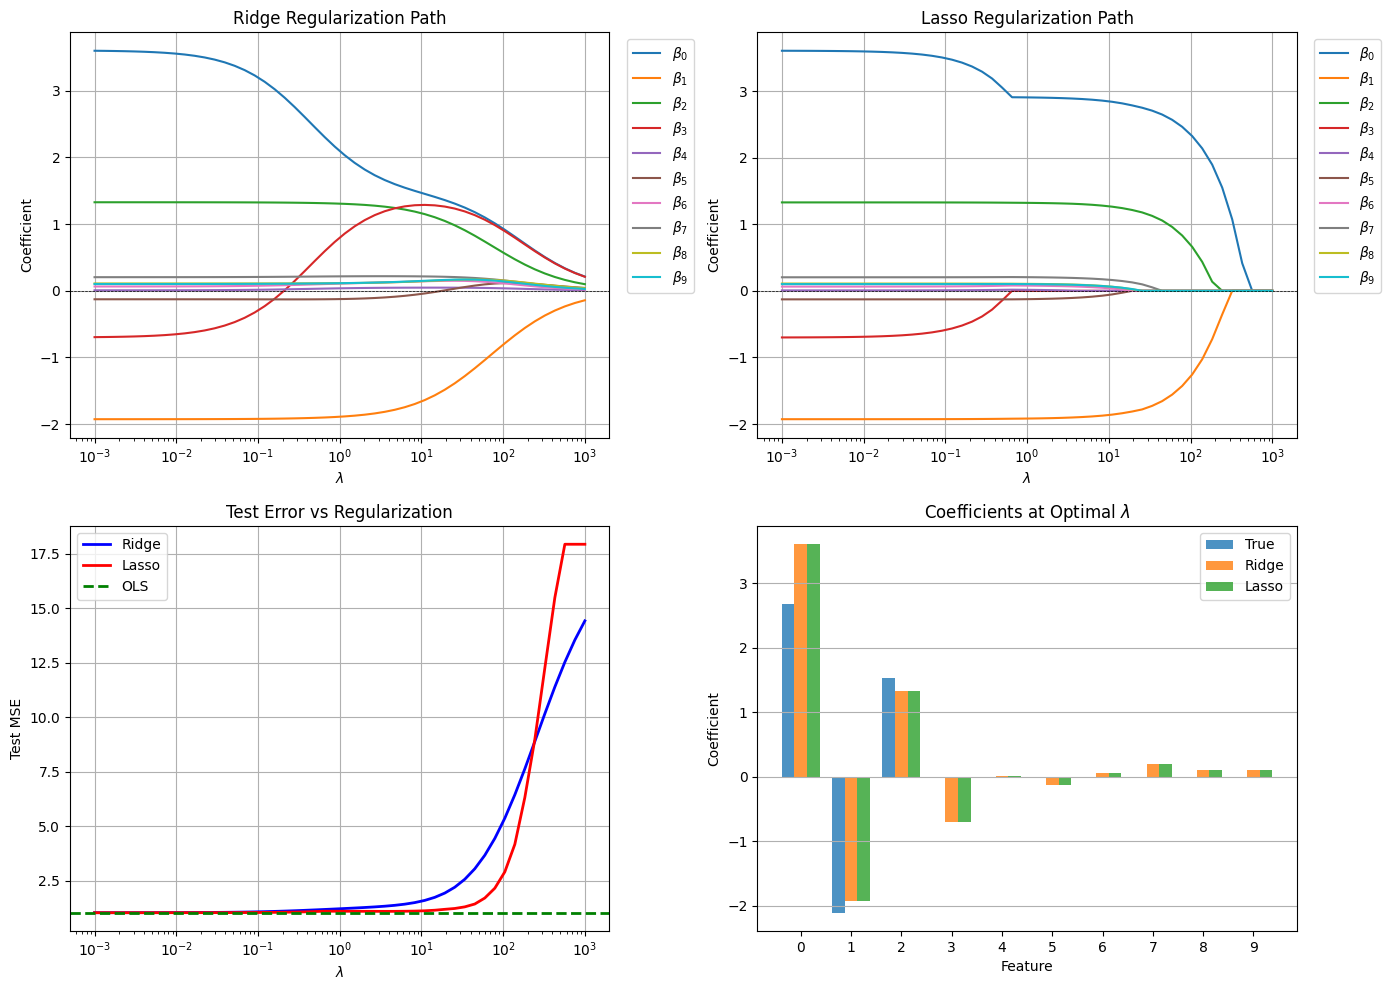


Optimal Ridge λ: 0.0010, Test MSE: 1.0391
Optimal Lasso λ: 0.0010, Test MSE: 1.0387
OLS Test MSE: 1.0386

Lasso non-zero coefficients: 10


In [9]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Ridge regularization path
for i in range(n_features):
    axes[0, 0].semilogx(lambdas, ridge_coefs[:, i], label=f'$\\beta_{i}$')
axes[0, 0].axhline(0, color='k', linestyle='--', linewidth=0.5)
axes[0, 0].set(xlabel='$\\lambda$', ylabel='Coefficient', title='Ridge Regularization Path')
axes[0, 0].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0, 0].grid(True)

# Plot 2: Lasso regularization path
for i in range(n_features):
    axes[0, 1].semilogx(lambdas, lasso_coefs[:, i], label=f'$\\beta_{i}$')
axes[0, 1].axhline(0, color='k', linestyle='--', linewidth=0.5)
axes[0, 1].set(xlabel='$\\lambda$', ylabel='Coefficient', title='Lasso Regularization Path')
axes[0, 1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0, 1].grid(True)

# Plot 3: Test MSE vs lambda
axes[1, 0].semilogx(lambdas, ridge_mse, 'b-', label='Ridge', linewidth=2)
axes[1, 0].semilogx(lambdas, lasso_mse, 'r-', label='Lasso', linewidth=2)
axes[1, 0].axhline(ols_mse, color='g', linestyle='--', label='OLS', linewidth=2)
axes[1, 0].set(xlabel='$\\lambda$', ylabel='Test MSE', title='Test Error vs Regularization')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Coefficient comparison at optimal lambda
opt_idx_ridge = np.argmin(ridge_mse)
opt_idx_lasso = np.argmin(lasso_mse)

x_pos = np.arange(n_features)
width = 0.25
axes[1, 1].bar(x_pos - width, true_beta * X_std, width, label='True', alpha=0.8)
axes[1, 1].bar(x_pos, ridge_coefs[opt_idx_ridge], width, label='Ridge', alpha=0.8)
axes[1, 1].bar(x_pos + width, lasso_coefs[opt_idx_lasso], width, label='Lasso', alpha=0.8)
axes[1, 1].set(xlabel='Feature', ylabel='Coefficient', title='Coefficients at Optimal $\\lambda$')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].legend()
axes[1, 1].grid(True, axis='y')

plt.tight_layout()
plt.show()

# Summary
print(f"\nOptimal Ridge λ: {lambdas[opt_idx_ridge]:.4f}, Test MSE: {ridge_mse[opt_idx_ridge]:.4f}")
print(f"Optimal Lasso λ: {lambdas[opt_idx_lasso]:.4f}, Test MSE: {lasso_mse[opt_idx_lasso]:.4f}")
print(f"OLS Test MSE: {ols_mse:.4f}")
print(f"\nLasso non-zero coefficients: {np.sum(np.abs(lasso_coefs[opt_idx_lasso]) > 1e-6)}")